In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ["OMP_NUM_THREADS"] = "2"
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


df = pd.read_csv('earthquake_data_tsunami.csv')
print("Размер:", df.shape)
print("Числовые атрибуты:", list(df.select_dtypes(include=[np.number]).columns))

Размер: (782, 13)
Числовые атрибуты: ['magnitude', 'cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth', 'latitude', 'longitude', 'Year', 'Month', 'tsunami']


In [3]:
df['tsunami_risk_score'] = (df['magnitude'] * 2 + (10 / (df['depth'] + 1)) + (5 / (df['dmin'] + 1)))
df['tsunami_risk_score'] = df['tsunami_risk_score'].round(3)
df['tsunami_risk_score'].head()
print("Дубликатов до:", df.duplicated().sum())
df = df.drop_duplicates()
print("Дубликатов после:", df.duplicated().sum())
print("Пропусков нет")
exclude_cols = ['Year', 'Month', 'tsunami']
numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns if col not in exclude_cols]
def remove_outliers_iqr(df, cols):
    df_clean = df.copy()
    for col in cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean
def remove_outliers_sigma(df, cols, sigma=3):
    df_clean = df.copy()
    for col in cols:
        mean = df_clean[col].mean()
        std = df_clean[col].std()
        lower = mean - sigma * std
        upper = mean + sigma * std
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean
df_clean = remove_outliers_iqr(df, numeric_cols)
print("Размер исходного датасета:", df.shape)
print("Размер после удаления выбросов:", df_clean.shape)

Дубликатов до: 0
Дубликатов после: 0
Пропусков нет
Размер исходного датасета: (782, 14)
Размер после удаления выбросов: (455, 14)


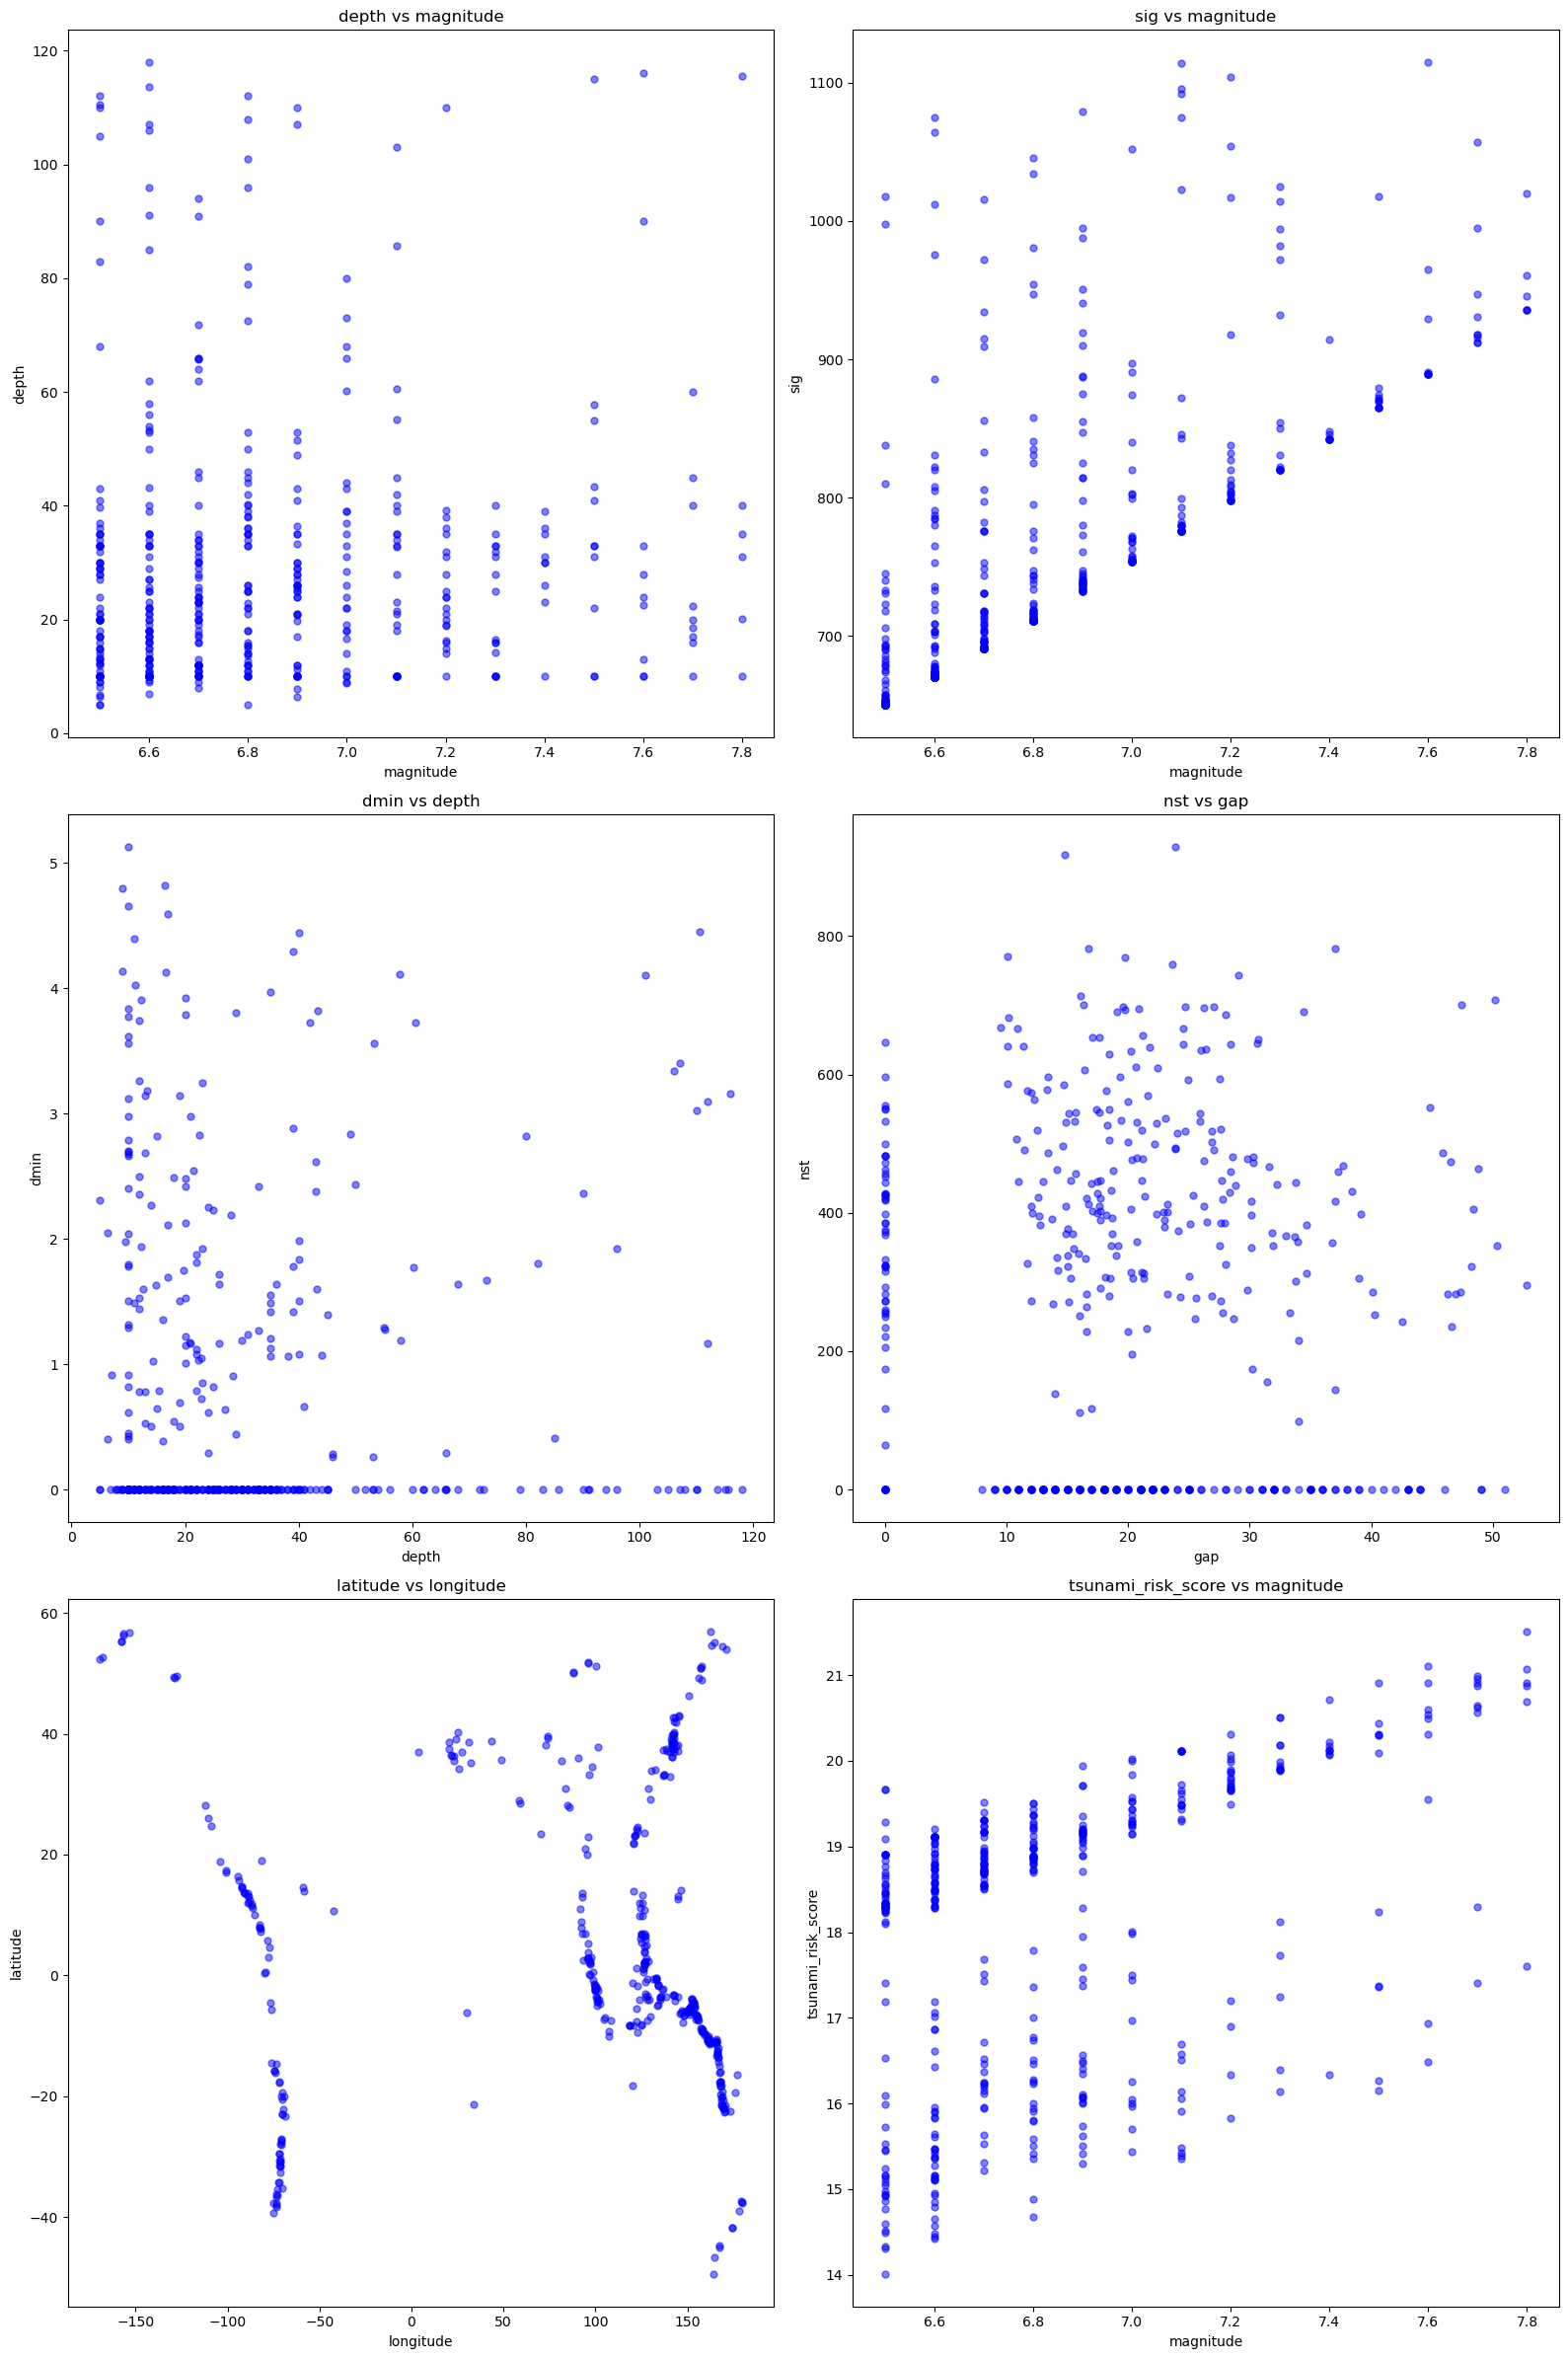

In [4]:
pairs = [('magnitude', 'depth'),('magnitude', 'sig'),('depth', 'dmin'),('gap', 'nst'),('longitude', 'latitude'),('magnitude', 'tsunami_risk_score')]
plt.figure(figsize=(16, 24))
for i, (x, y) in enumerate(pairs, 1):
    plt.subplot(3, 2, i)
    plt.scatter(df_clean[x], df_clean[y], alpha=0.5, s=25, color='blue')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f"{y} vs {x}")
plt.tight_layout()
plt.show()

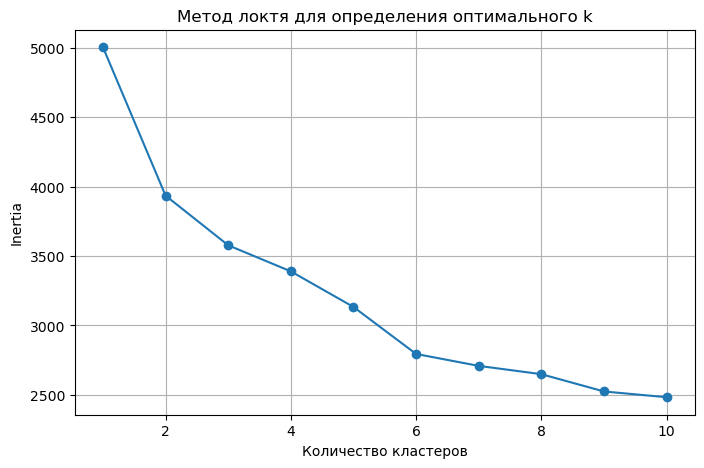

In [5]:
X = df_clean[numeric_cols].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
inertia = []
K = range(1, 11)
for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertia.append(model.inertia_)
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')
plt.title('Метод локтя для определения оптимального k')
plt.grid(True)
plt.show()

In [6]:
#k = 4
#kmeans = KMeans(n_clusters=k, random_state=42)
#df_clean['cluster'] = kmeans.fit_predict(X_scaled)

#plt.figure(figsize=(10, 7))
#scatter = plt.scatter(df_clean['longitude'], df_clean['latitude'], c=df_clean['cluster'], cmap='viridis', alpha=0.5, s=30)
#plt.colorbar(scatter, label="Cluster")
#plt.xlabel('longitude')
#plt.ylabel('latitude')
#plt.title('Кластеры KMeans: longitude vs latitude')

#plt.figure(figsize=(10, 7))
#scatter = plt.scatter(df_clean['magnitude'], df_clean['depth'], c=df_clean['cluster'], cmap='viridis', alpha=0.5, s=30)
#plt.colorbar(scatter, label="Cluster")
#plt.xlabel('magnitude')
#plt.ylabel('depth')
#plt.title('Кластеры KMeans: magnitude vs depth')

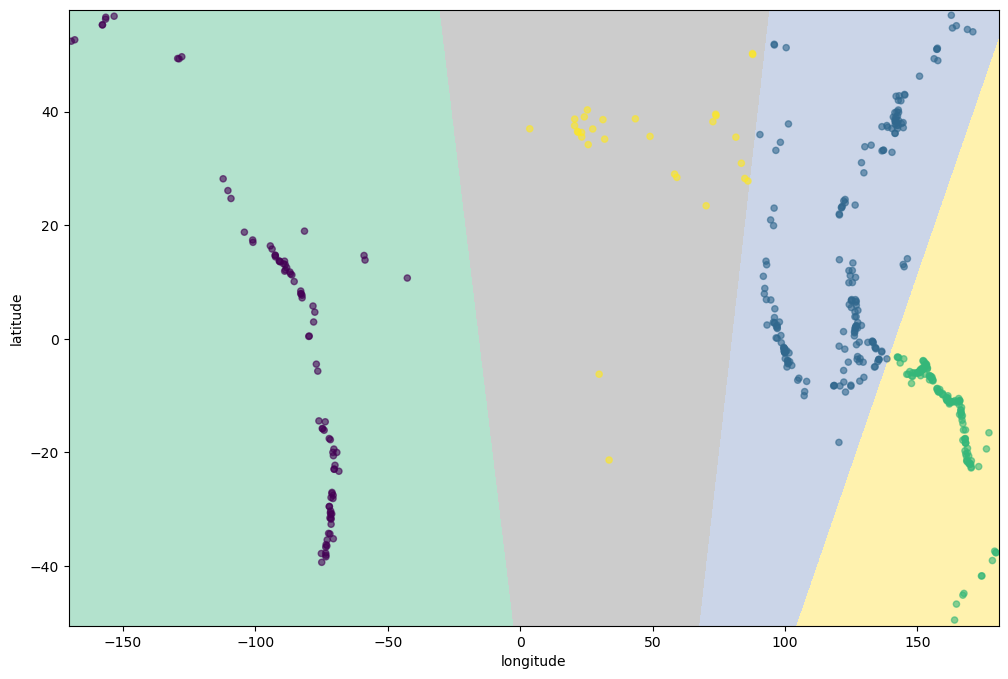

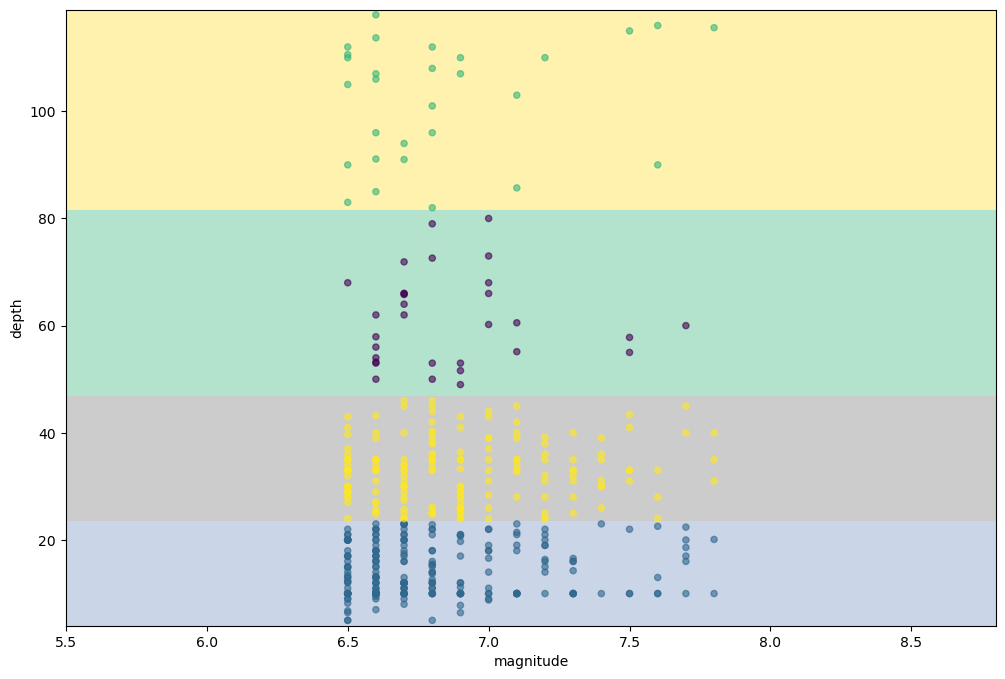

In [7]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')

X_plot = df_clean[['longitude', 'latitude']].values
labels = kmeans.fit_predict(X_plot)
centroids = kmeans.cluster_centers_

x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(12, 8))
plt.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap=plt.cm.Pastel2, aspect='auto', origin='lower')
plt.scatter(X_plot[:, 0], X_plot[:, 1], c=labels, s=20, cmap='viridis', alpha=0.6)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

X_plot = df_clean[['magnitude', 'depth']].values
labels = kmeans.fit_predict(X_plot)

x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(12, 8))
plt.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap=plt.cm.Pastel2, aspect='auto', origin='lower')
plt.scatter(X_plot[:, 0], X_plot[:, 1], c=labels, s=20, cmap='viridis', alpha=0.6)
plt.xlabel('magnitude')
plt.ylabel('depth')
plt.show()

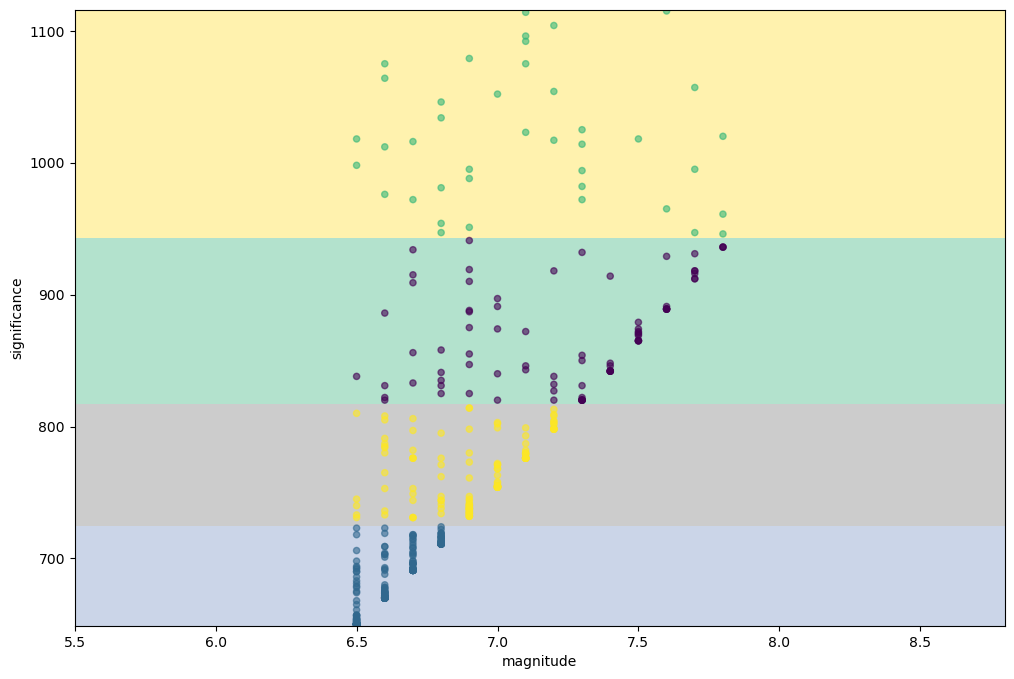

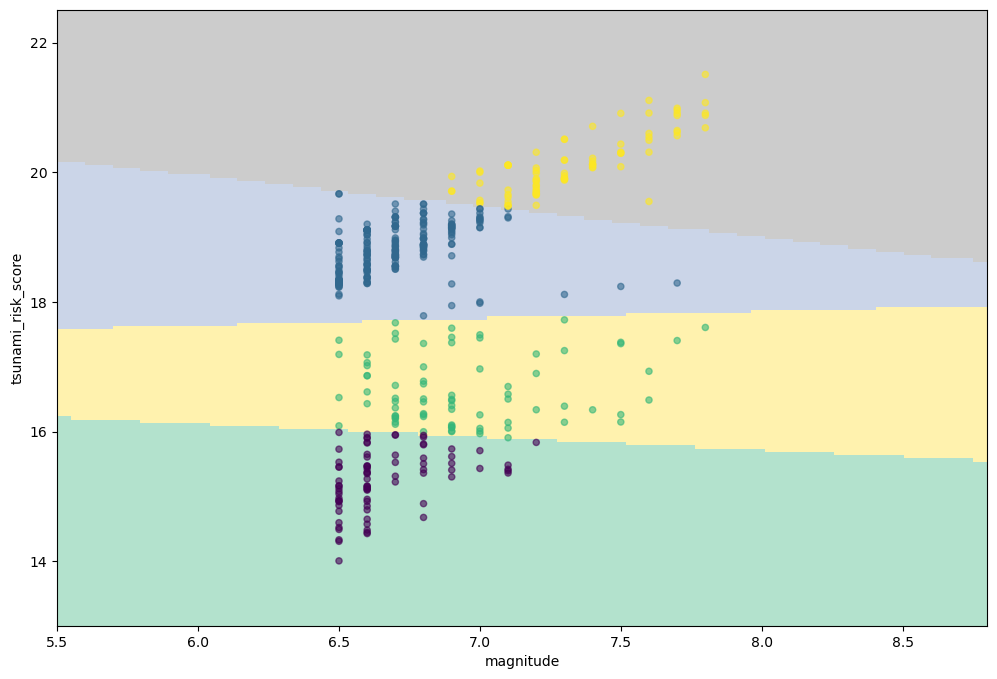

In [8]:
X_plot = df_clean[['magnitude', 'sig']].values
labels = kmeans.fit_predict(X_plot)

x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(12, 8))
plt.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap=plt.cm.Pastel2, aspect='auto', origin='lower')
plt.scatter(X_plot[:, 0], X_plot[:, 1], c=labels, s=20, cmap='viridis', alpha=0.6)
plt.xlabel('magnitude')
plt.ylabel('significance')
plt.show()

X_plot = df_clean[['magnitude', 'tsunami_risk_score']].values
labels = kmeans.fit_predict(X_plot)

x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(12, 8))
plt.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap=plt.cm.Pastel2, aspect='auto', origin='lower')
plt.scatter(X_plot[:, 0], X_plot[:, 1], c=labels, s=20, cmap='viridis', alpha=0.6)
plt.xlabel('magnitude')
plt.ylabel('tsunami_risk_score')
plt.show()

In [9]:
print("Выводы:")
print("1. Метод локтя успешно определил оптимальное количество кластеров: k = 4.")
print("2. Географические кластеры (longitude vs latitude) образуют зоны сейсмической активности, где землетрясения")
print("концентрируются в наиболее опасных регионах.")
print("3. На графике (magnitude vs depth) землетрясения формируют группы, разделённые по глубине:")
print("поверхностные, средние, глубокие, очень глубокие.")
print("4. Наиболее опасные (sig) землетрясения соответствуют сильным по magnitude.")

Выводы:
1. Метод локтя успешно определил оптимальное количество кластеров: k = 4.
2. Географические кластеры (longitude vs latitude) образуют зоны сейсмической активности, где землетрясения
концентрируются в наиболее опасных регионах.
3. На графике (magnitude vs depth) землетрясения формируют группы, разделённые по глубине:
поверхностные, средние, глубокие, очень глубокие.
4. Наиболее опасные (sig) землетрясения соответствуют сильным по magnitude.
